## ChatGLM2 + Lora + Agent
ChatGLM2-6B 是开源中英双语对话模型 ChatGLM-6B 的第二代版本，在保留了初代模型对话流畅、部署门槛较低等众多优秀特性的基础之上，ChatGLM2-6B 引入了如下新特性：

1. 更强大的性能：基于 ChatGLM 初代模型的开发经验，我们全面升级了 ChatGLM2-6B 的基座模型。ChatGLM2-6B 使用了 GLM 的混合目标函数，经过了 1.4T 中英标识符的预训练与人类偏好对齐训练，评测结果显示，相比于初代模型，ChatGLM2-6B 在 MMLU（+23%）、CEval（+33%）、GSM8K（+571%） 、BBH（+60%）等数据集上的性能取得了大幅度的提升，在同尺寸开源模型中具有较强的竞争力。

2. 更长的上下文：基于 FlashAttention 技术，我们将基座模型的上下文长度（Context Length）由 ChatGLM-6B 的 2K 扩展到了 32K，并在对话阶段使用 8K 的上下文长度训练，允许更多轮次的对话。但当前版本的 ChatGLM2-6B 对单轮超长文档的理解能力有限，我们会在后续迭代升级中着重进行优化。

3. 更高效的推理：基于 Multi-Query Attention 技术，ChatGLM2-6B 有更高效的推理速度和更低的显存占用：在官方的模型实现下，推理速度相比初代提升了 42%，INT4 量化下，6G 显存支持的对话长度由 1K 提升到了 8K。

1. Ref: https://modelscope.cn/models/ZhipuAI/chatglm2-6b/summary
2. 以下脚本可以在2*A10环境下正常运行, 大概占用40G显存
3. python>=3.8

### 配置实验环境
The following code is copied from baichuan_sft.ipynb

In [ ]:
# !pip install modelscope -U
# !pip install numpy pandas matplotlib scikit-learn
# !pip install transformers datasets
# !conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# !pip install tqdm
# !pip install tensorboard
# !pip install torchmetrics
#
# !pip install numpy -U  # Resolve torchmetrics dependencies and update numpy

In [ ]:
from _common import *
device_ids = list(range(min(4, torch.cuda.device_count())))
logger.info(device_ids)
select_device(device_ids)
_ = seed_everything(42)

[2023-07-02 20:34:35,987] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-07-02 20:34:36,464 - modelscope - INFO - PyTorch version 2.0.1 Found.
2023-07-02 20:34:36,465 - modelscope - INFO - Loading ast index from /home/hackathon/.cache/modelscope/ast_indexer
2023-07-02 20:34:36,489 - modelscope - INFO - Loading done! Current index file version is 1.6.2, with md5 ddf811ee982377c1357284a2bfda3dec and a total number of 861 components indexed
2023-07-02 20:34:37,158 - modelscope - INFO - [0, 1]
2023-07-02 20:34:37,324 - modelscope - INFO - Using device: cuda:0,1
2023-07-02 20:34:37,326 - modelscope - INFO - Global seed set to 42


### 导入Model, Tokenizer

In [ ]:
model_id = 'ZhipuAI/chatglm2-6b'
WORK_DIR = 'runs/chatglm2'
LORA_TARGET_MODULES = ['query_key_value']
#
model_dir = get_model_dir(model_id, None)
model, tokenizer = get_chatglm2_model_tokenizer(model_dir)
# chatglm2 does not support gradient_checkpointing
GRADIENT_CHECKPOINTING = False
if GRADIENT_CHECKPOINTING:
    model.gradient_checkpointing_enable()
    model.enable_input_require_grads()
logger.info(tokenizer.special_tokens)
if tokenizer.eos_token_id is None:
    tokenizer.eos_token_id = tokenizer.pad_token_id
if tokenizer.bos_token_id is None:
    tokenizer.bos_token_id = 1
#
logger.info(f'bos_token_id: {tokenizer.bos_token_id}, eos_token_id: {tokenizer.eos_token_id}, '
            f'pad_token_id: {tokenizer.pad_token_id}')

2023-07-02 20:34:37,660 - modelscope - INFO - Development mode use revision: v1.0.3
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ChatGLMTokenizer'. 
The class this function is called from is 'ChatGLM2Tokenizer'.
2023-07-02 20:34:38,020 - modelscope - INFO - initialize model from /home/hackathon/.cache/modelscope/hub/ZhipuAI/chatglm2-6b
Failed to load cpm_kernels:No module named 'cpm_kernels'
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

2023-07-02 20:34:45,151 - modelscope - INFO - {'<bos>': 1, '<eos>': 2, '<pad>': 2}
2023-07-02 20:34:45,152 - modelscope - INFO - bos_token_id: 1, eos_token_id: 2, pad_token_id: 2


### 准备Lora
The following code is copied from baichun.ipynb

In [ ]:
LORA_RANK = 8
LORA_ALPHA = 32
LORA_DROPOUT_P = 0.1
lora_config = LoRAConfig(
    replace_modules=LORA_TARGET_MODULES,
    rank=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT_P)
logger.info(f'lora_config: {lora_config}')
Swift.prepare_model(model, lora_config)
#
show_freeze_layers(model)
print_model_info(model)
_p = list(model.parameters())[100]
logger.info(f'device: {_p.device}, dtype: {_p.dtype}')
model.bfloat16()

2023-07-02 20:34:45,215 - modelscope - INFO - lora_config: LoRAConfig(rank=8, replace_modules=['query_key_value'], lora_alpha=32, lora_dropout=0.1, merge_weights=True, use_merged_linear=False, enable_lora=None, fan_in_fan_out=False, bias='none', only_lora_trainable=True, pretrained_weights=None)
2023-07-02 20:34:49,932 - modelscope - INFO - transformer.embedding.word_embeddings.weight: requires_grad=False
2023-07-02 20:34:49,933 - modelscope - INFO - transformer.encoder.layers.0.input_layernorm.weight: requires_grad=False
2023-07-02 20:34:49,933 - modelscope - INFO - transformer.encoder.layers.0.self_attention.query_key_value.weight: requires_grad=False
2023-07-02 20:34:49,933 - modelscope - INFO - transformer.encoder.layers.0.self_attention.query_key_value.bias: requires_grad=False
2023-07-02 20:34:49,934 - modelscope - INFO - transformer.encoder.layers.0.self_attention.query_key_value.lora_A: requires_grad=True
2023-07-02 20:34:49,934 - modelscope - INFO - transformer.encoder.layers.

ChatGLM2ForConditionalGeneration(
  (transformer): ChatGLMModel(
    (embedding): Embedding(
      (word_embeddings): Embedding(65024, 4096)
    )
    (rotary_pos_emb): RotaryEmbedding()
    (encoder): GLMTransformer(
      (layers): ModuleList(
        (0-27): 28 x GLMBlock(
          (input_layernorm): RMSNorm()
          (self_attention): SelfAttention(
            (query_key_value): Linear(
              in_features=4096, out_features=4608, bias=True
              (lora_dropout): Dropout(p=0.1, inplace=False)
            )
            (core_attention): CoreAttention(
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (dense): Linear(in_features=4096, out_features=4096, bias=False)
          )
          (post_attention_layernorm): RMSNorm()
          (mlp): MLP(
            (dense_h_to_4h): Linear(in_features=4096, out_features=27392, bias=False)
            (dense_4h_to_h): Linear(in_features=13696, out_features=4096, bias=False)
          )


### 导入Dataset
The following code is copied from baichuan_sft.ipynb

In [ ]:
tokenize_function = partial(tokenize_function, tokenizer=tokenizer)
train_dataset = make_dataset('train', tokenize_function)
val_dataset = make_dataset('validation', tokenize_function)
# Data analysis
stat_dataset(train_dataset)
stat_dataset(val_dataset)
data_collate_fn = partial(data_collate_fn, tokenizer=tokenizer)
print_examples(train_dataset[0], tokenizer)

2023-07-02 20:34:50,040 - modelscope - INFO - No subset_name specified, defaulting to the default
2023-07-02 20:34:50,479 - modelscope - WARNING - Reusing dataset ms_hackathon_23_agent_train_dev (/home/hackathon/.cache/modelscope/hub/datasets/modelscope/ms_hackathon_23_agent_train_dev/master/data_files)
2023-07-02 20:34:50,479 - modelscope - INFO - Generating dataset ms_hackathon_23_agent_train_dev (/home/hackathon/.cache/modelscope/hub/datasets/modelscope/ms_hackathon_23_agent_train_dev/master/data_files)
2023-07-02 20:34:50,480 - modelscope - INFO - Reusing cached meta-data file: /home/hackathon/.cache/modelscope/hub/datasets/modelscope/ms_hackathon_23_agent_train_dev/master/data_files/8c9e7b1aa666c8840cb938d877f2b99f


Extracting data files: 0it [00:00, ?it/s]

100%|██████████| 5036/5036 [00:12<00:00, 403.83it/s]
2023-07-02 20:35:03,823 - modelscope - INFO - No subset_name specified, defaulting to the default
2023-07-02 20:35:04,269 - modelscope - WARNING - Reusing dataset ms_hackathon_23_agent_train_dev (/home/hackathon/.cache/modelscope/hub/datasets/modelscope/ms_hackathon_23_agent_train_dev/master/data_files)
2023-07-02 20:35:04,270 - modelscope - INFO - Generating dataset ms_hackathon_23_agent_train_dev (/home/hackathon/.cache/modelscope/hub/datasets/modelscope/ms_hackathon_23_agent_train_dev/master/data_files)
2023-07-02 20:35:04,270 - modelscope - INFO - Reusing cached meta-data file: /home/hackathon/.cache/modelscope/hub/datasets/modelscope/ms_hackathon_23_agent_train_dev/master/data_files/941b733ec0354c2172a3386d8788bb37


Extracting data files: 0it [00:00, ?it/s]

100%|██████████| 285/285 [00:00<00:00, 380.76it/s]
2023-07-02 20:35:05,192 - modelscope - INFO - Dataset Token Length: 888.357487±349.060492, min=48.000000, max=2039.000000, size=4982
2023-07-02 20:35:05,192 - modelscope - INFO - Dataset Token Length: 928.654804±330.133929, min=74.000000, max=1959.000000, size=281


[INPUT_IDS] 你是达摩院的ModelScopeGPT（魔搭助手），你是个大语言模型， 是2023年达摩院的工程师训练得到的。你有多种能力，可以通过插件集成魔搭社区的模型api来回复用户的问题，还能解答用户使用模型遇到的问题和模型知识相关问答。1. {"plugin_name": "modelscope_text-ie", "plugin_owner": "ModelScopeGPT", "plugin_type": "default", "plugin_schema_for_model": {"name": "modelscope_text-ie", "description": "针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示", "url": "http://109.199.101.10:1485/", "paths": [{"name": "modelscope_text-ie", "model_id": "/damo/nlp_structbert_siamese-uie_chinese-base", "method": "post", "description": "针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示", "parameters": [{"name": "text", "description": "用户输入的文本", "required": "True"}, {"name": "schema", "description": "要抽取信息的json表示", "required": "True"}]}]}}

2. {"plugin_name": "modelscope_text-ie", "plugin_owner": "ModelScopeGPT", "plugin_type": "default", "plugin_schema_for_model": {"name": "modelscope_text-ie", "description": "针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示", "url": "http://9.32.64.200:5873/", "paths": [{"name": "modelsc

### 配置Config
The following code is copied from baichuan_sft.ipynb

In [ ]:
cfg_file = os.path.join(model_dir, 'configuration.json')
#
BATCH_SIZE = 1
MAX_EPOCHS = 1
T_max = get_T_max(len(train_dataset), BATCH_SIZE, MAX_EPOCHS, True)
WORK_DIR = get_work_dir(WORK_DIR)
EVAL_INTERVAL = 200
CONFIG = Config({
    'train': {
        'dataloader': {
            'batch_size_per_gpu': BATCH_SIZE,
            'workers_per_gpu': 1,
            'shuffle': True,
            'drop_last': True,
            'pin_memory': True
        },
        'max_epochs': MAX_EPOCHS,
        'work_dir': WORK_DIR,
        'optimizer': {
            'type': 'AdamW',
            'lr': 1e-4,
            'weight_decay': 0.01,
            'options': {
                'cumulative_iters': 16, 'grad_clip': {
                    'norm_type': 2,
                    'max_norm': 2.0
                }
            }
        },
        'lr_scheduler': {
            'type': 'CosineAnnealingLR',
            'T_max': T_max,
            'eta_min': 1e-5,
            'options': {
                'by_epoch': False,
                'warmup': {
                    'type': 'LinearWarmup',
                    'warmup_ratio': 0.1,
                    'warmup_iters': 200
                }
            }
        },
        'hooks': [
            {'type': 'CheckpointHook', 'by_epoch': False,
                'interval': EVAL_INTERVAL, 'max_checkpoint_num': 1},
            {'type': 'EvaluationHook', 'by_epoch': False, 'interval': EVAL_INTERVAL},
            {'type': 'BestCkptSaverHook',
                'metric_key': 'acc',
                'save_best': True, 'rule': 'max', 'max_checkpoint_num': 1},
            {'type': 'TextLoggerHook',
                'by_epoch': True,  # Whether EpochBasedTrainer is used
                'interval': 5},
            {'type': 'TensorboardHook', 'by_epoch': False, 'interval': 5}
        ]
    },
    'evaluation': {
        'dataloader': {
            'batch_size_per_gpu': BATCH_SIZE,
            'workers_per_gpu': 1,
            'shuffle': False,
            'drop_last': False,
            'pin_memory': True
        },
        'metrics': [
            {'type': 'my_metric', 'vocab_size': tokenizer.vocab_size}
        ]
    }
})

2023-07-02 20:35:05,244 - modelscope - INFO - work_dir: /home/hackathon/my_git/agent/runs/chatglm2/v1-20230702-203505


### 微调
The following code is copied from baichuan_sft.ipynb

In [ ]:
def cfg_modify_fn(cfg: Config) -> Config:
    cfg.update(CONFIG)
    return cfg


trainer = EpochBasedTrainer(
    model=model,
    cfg_file=cfg_file,
    data_collator=data_collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    remove_unused_data=True,
    seed=42,
    device='cpu',  # No placement for model, leave the model to `device_map`
    cfg_modify_fn=cfg_modify_fn,
)

trainer.train()

2023-07-02 20:35:05,284 - modelscope - INFO - ==========================Training Config Start==========================
2023-07-02 20:35:05,285 - modelscope - INFO - {
    "framework": "pytorch",
    "task": "chat",
    "pipeline": {
        "type": "chatglm26b-text-generation"
    },
    "allow_remote": true,
    "train": {
        "hooks": [
            {
                "type": "TensorboardHook",
                "by_epoch": false,
                "interval": 5
            }
        ],
        "dataloader": {
            "batch_size_per_gpu": 1,
            "workers_per_gpu": 1,
            "shuffle": true,
            "drop_last": true,
            "pin_memory": true
        },
        "max_epochs": 1,
        "work_dir": "/home/hackathon/my_git/agent/runs/chatglm2/v1-20230702-203505",
        "optimizer": {
            "type": "AdamW",
            "lr": 0.0001,
            "weight_decay": 0.01,
            "options": {
                "cumulative_iters": 16,
                "grad_c

### 可视化
tensorboard 命令: (e.g.)  
`tensorboard --logdir /home/hackathon/my_git/agent/runs/chatglm2/v1-20230702-203505 --port 6006`


The following code is copied from baichuan_sft.ipynb

dict_keys(['lr', 'loss', 'evaluation/acc', 'evaluation/loss'])


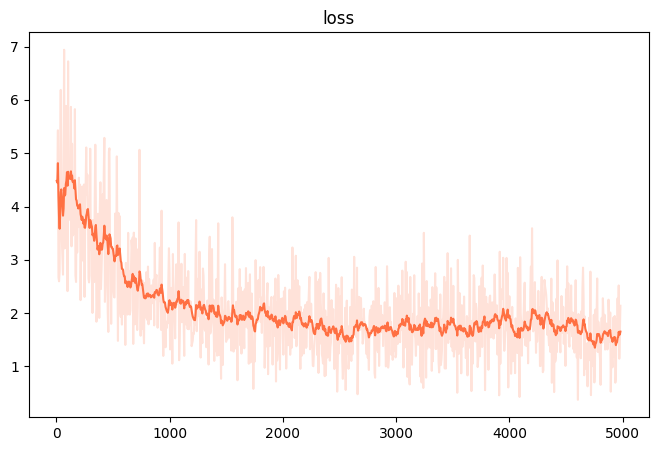

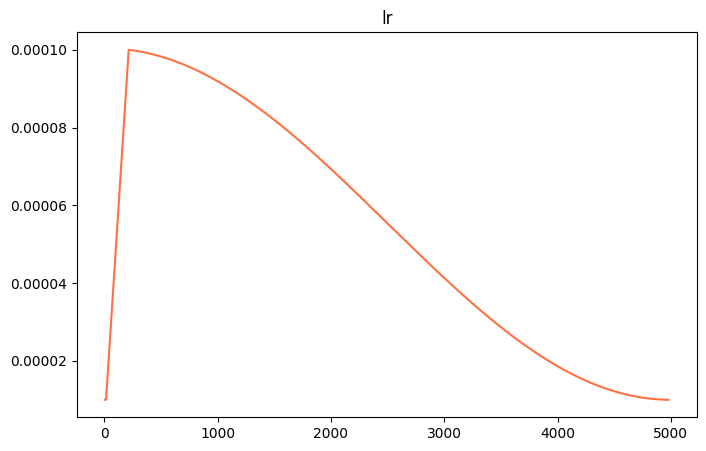

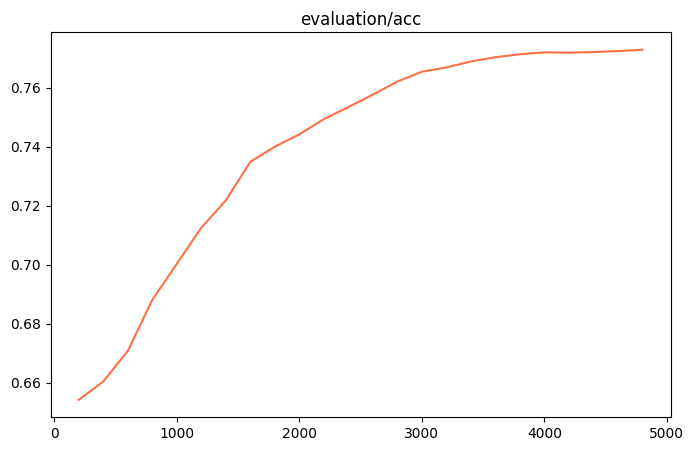

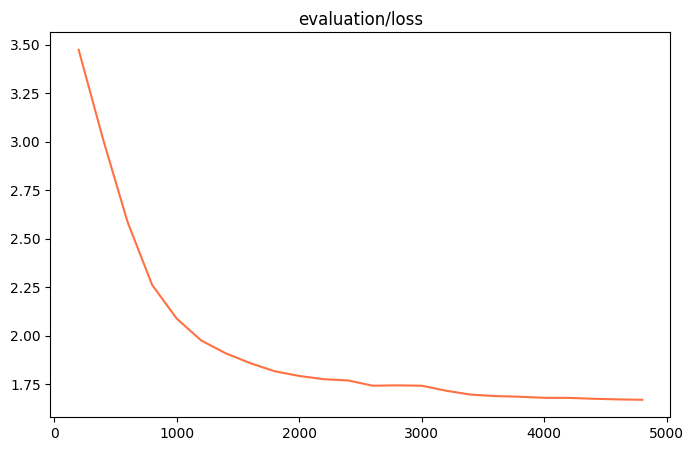

In [ ]:
tb_dir = os.path.join(WORK_DIR, 'tensorboard_output')
fname = os.listdir(tb_dir)[0]
tb_path = os.path.join(tb_dir, fname)
#
data = read_tensorboard_file(tb_path)
print(data.keys())
_ = plot_image(data, 'loss', 0.9)
_ = plot_image(data, 'lr', 0)
_ = plot_image(data, 'evaluation/acc', 0)
_ = plot_image(data, 'evaluation/loss', 0)

### 推理
推理部分见chatglm2_infer.ipynb